In [29]:
import os
import sys

sys.path.append('../SeismicPro/seismicpro')

import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

import pymeanshift as pms

from batchflow import Dataset, FilesIndex, Pipeline, B, V
from batchflow.models.torch import TorchModel, UNet

from preprocessing import (create_mask, draw_plots, sigmoid,
                           calculate_distance, filter_prediction, FermiDataset,
                           RandomCropNearPoints, list_crop, assemble_imgs, find_optimal_thr)
from batch import FermiBatch

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=1

plt.style.use('ggplot')

env: CUDA_VISIBLE_DEVICES=1


In [2]:
ix = FilesIndex(path='./../new_data/input_data/data/*')
dset = Dataset(ix, batch_class=FermiBatch)
dset.split()

In [3]:
SIZE = 40
prep_pipeline = (Pipeline()
                .load('fermi', components=['images', 'points'])
                .generate_masks(src='points', dst='masks')
                .normalize(src='images') 
                .random_crop_near_points(prob=0.5, output_size=SIZE, src=['images', 'masks'])
                .prepare_tensors('images', add_dim=True)
                .prepare_tensors('masks')
)

In [4]:
inputs_config = {
    'images': {'shape': (1, SIZE, SIZE)}, 
    'masks': {'shape': (SIZE, SIZE),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

w = torch.Tensor([1., 10.]).to('cuda')
config = {
    'loss': {'name':'ce', 'weight': w},
    'inputs': inputs_config,
    'initial_block/inputs': 'images',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': [8, 16, 32, 64], 
    'body/encoder': dict(layout='cna cna', kernel_size=3),
    'body/decoder': dict(layout='cna cna', kernel_size=3),
    'device': 'cuda',
}

In [5]:
train_ppl = (prep_pipeline + (Pipeline()
            .init_model('dynamic', UNet, 'model', config)
            .init_variable('loss', init_on_each_run=list)
            .train_model('model', B('images'), B('masks'), 
                       fetches='loss', save_to=V('loss'), mode='a'))
) << dset.train

test_ppl = (prep_pipeline + (Pipeline()
                             .import_model('model', train_ppl)
                             .init_variable('loss', init_on_each_run=list)
                             .init_variable('targets', init_on_each_run=list)
                             .init_variable('predictions', init_on_each_run=list)
                             .predict_model('model', B('images'), B('masks'), 
                                            fetches=['predictions', 'loss'], 
                                            save_to=[V('predictions'), V('loss')], mode='a')
                             .update_variable('targets', B('masks'), mode='a')
                            )) << dset.test

In [ ]:
from tqdm import tqdm

N_EPOCHS = 200
train_loss = []
test_loss = []
for i in tqdm(range(N_EPOCHS)):
    train_ppl.run(64, n_epochs=1, shuffle=True, drop_last=True)
    test_ppl.run(64, n_epochs=1, shuffle=True, drop_last=True)
    train_loss.append(np.mean(train_ppl.get_variable('loss')))
    test_loss.append(np.mean(test_ppl.get_variable('loss')))

 21%|██        | 42/200 [14:11<53:33, 20.34s/it]

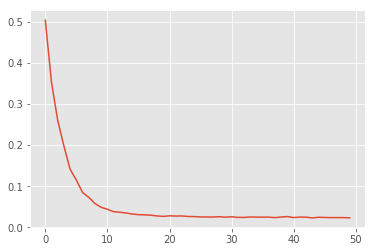

In [8]:
plt.plot(test_loss)

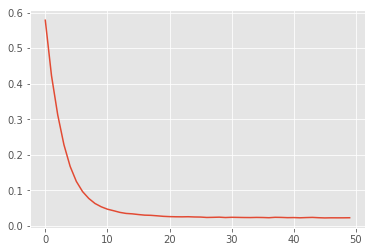

In [7]:
plt.plot(train_loss)

In [28]:
train_ppl.save_model('model', 'best_model')

In [9]:
load_ppl = (Pipeline()
            .load('fermi', components=['images', 'points'])
            .generate_masks(src='points', dst='masks')
            .normalize(src='images') 
            .prepare_tensors('images', add_dim=True)
            .prepare_tensors('masks')
            .init_variable('imag', init_on_each_run=list)
            .init_variable('mask', init_on_each_run=list)
            .update_variable('mask', B('masks'), mode='a')
            .update_variable('imag', B('images'), mode='a')
)

In [10]:
model = train_ppl.get_model_by_name('model')

In [11]:
test_data_ppl = (load_ppl << dset.test).run(1, n_epochs=1, shuffle=False, drop_last=False)

In [12]:
images = np.concatenate(np.concatenate(test_data_ppl.get_variable('imag')))
masks = np.concatenate(test_data_ppl.get_variable('mask'))

In [13]:
val_images, te_images = images[:int(len(images)/2)], images[int(len(images)/2):]
val_masks, te_masks = masks[:int(len(masks)/2)], masks[int(len(masks)/2):]

And let's find an optimal threshold parameter.

In [14]:
def find_optimal_thr_1(model, images, masks, threshold):
    g_dist = []
    for tr in tqdm(threshold):
        dist = []
        for img, msk in zip(images, masks):
            img_tens = torch.Tensor(list_crop(img.reshape(1, 200, 200), 40))
            img_sigm = sigmoid(model.model(img_tens.to('cuda')).cpu().detach().numpy()).transpose(0, 2, 3, 1)[:,:,:,1]
            assemble_img = assemble_imgs(img_sigm, (200, 200))
            filt_pred = filter_prediction(np.array(assemble_img > tr))
            img = np.array(np.where(filt_pred > tr)).T
            mask = np.array(np.where(msk)).T
            dist.append(calculate_distance(img, mask))
        g_dist.append(np.mean(dist))
    return g_dist, threshold[np.argmin(g_dist)]

In [15]:
threshold_list = np.linspace(.2, .9, 20)
g_dist, threshold = find_optimal_thr_1(model, val_images, val_masks, threshold_list)


100%|██████████| 20/20 [01:47<00:00,  5.08s/it]

Have a look on the dependence between threshold and distance.

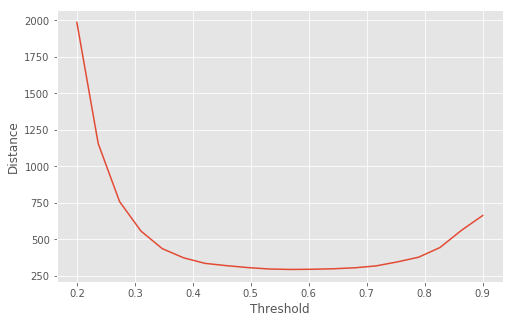

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(threshold_list, g_dist);
plt.xlabel('Threshold')
plt.ylabel('Distance')
plt.show()

Now let's look at the quality of the model on the test data with the previously calculated threshold.

In [19]:
dist = []
preds = []
tr = threshold
i = 0
ans = []
points = []
for img, msk in list(zip(te_images, te_masks)):
    img_tens = torch.Tensor(list_crop(img.reshape(1, 200, 200), 40))
    img_sigm = sigmoid(model.model(img_tens.to('cuda')).cpu().detach().numpy()).transpose(0, 2, 3, 1)[:,:,:,1]
    assemble_img = assemble_imgs(img_sigm, (200, 200))
    pr = np.array(assemble_img > tr)
    filt = filter_prediction(pr)
    preds.append(filt)
    img = np.array(np.where(filt > tr)).T
    mask = np.array(np.where(msk)).T
    ans.append(img)
    points.append(mask)
    dist.append(calculate_distance(img, mask))


In [20]:
print("Unet mean distance is: {:.6}".format(np.mean(dist)))

Unet mean distance is: 291.976


In [30]:
SIZE = 40
prep_pipeline = (Pipeline()
                .load('fermi', components=['images', 'points'])
                .generate_masks(src='points', dst='masks')
                .normalize(src='images') 
                .random_crop_near_points(prob=0.5, output_size=SIZE, src=['images', 'masks'])
                .prepare_tensors('images', add_dim=True)
                .prepare_tensors('masks')
)

In [32]:
inputs_config = {
    'images': {'shape': (1, SIZE, SIZE)}, 
    'masks': {'shape': (SIZE, SIZE),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

w = torch.Tensor([1., 10.]).to('cuda')
config = {
    'loss': {'name':'ce', 'weight': w},
    'inputs': inputs_config,
    'initial_block/inputs': 'images',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': [16, 32, 64, 128], 
    'body/encoder': dict(layout='cna cna', kernel_size=3),
    'body/decoder': dict(layout='cna cna', kernel_size=3),
    'device': 'cuda',
}

In [33]:
train_ppl = (prep_pipeline + (Pipeline()
            .init_model('dynamic', UNet, 'model', config)
            .init_variable('loss', init_on_each_run=list)
            .train_model('model', B('images'), B('masks'), 
                       fetches='loss', save_to=V('loss'), mode='a'))
) << dset.train

test_ppl = (prep_pipeline + (Pipeline()
                             .import_model('model', train_ppl)
                             .init_variable('loss', init_on_each_run=list)
                             .init_variable('targets', init_on_each_run=list)
                             .init_variable('predictions', init_on_each_run=list)
                             .predict_model('model', B('images'), B('masks'), 
                                            fetches=['predictions', 'loss'], 
                                            save_to=[V('predictions'), V('loss')], mode='a')
                             .update_variable('targets', B('masks'), mode='a')
                            )) << dset.test

In [34]:
from tqdm import tqdm

N_EPOCHS = 50
train_loss = []
test_loss = []
for i in tqdm(range(N_EPOCHS)):
    train_ppl.run(64, n_epochs=1, shuffle=True, drop_last=True)
    test_ppl.run(64, n_epochs=1, shuffle=True, drop_last=True)
    train_loss.append(np.mean(train_ppl.get_variable('loss')))
    test_loss.append(np.mean(test_ppl.get_variable('loss')))


100%|██████████| 50/50 [15:02<00:00, 20.14s/it]

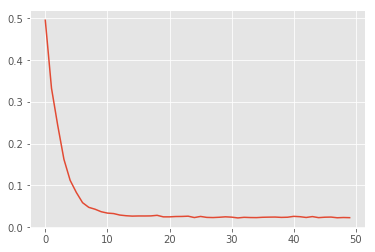

In [35]:
plt.plot(test_loss)

In [36]:
train_ppl.save_model('model', 'big_model_new_type_model')

In [37]:
load_ppl = (Pipeline()
            .load('fermi', components=['images', 'points'])
            .generate_masks(src='points', dst='masks')
            .normalize(src='images') 
            .prepare_tensors('images', add_dim=True)
            .prepare_tensors('masks')
            .init_variable('imag', init_on_each_run=list)
            .init_variable('mask', init_on_each_run=list)
            .update_variable('mask', B('masks'), mode='a')
            .update_variable('imag', B('images'), mode='a')
)

In [38]:
model = train_ppl.get_model_by_name('model')

In [39]:
test_data_ppl = (load_ppl << dset.test).run(1, n_epochs=1, shuffle=False, drop_last=False)

In [40]:
images = np.concatenate(np.concatenate(test_data_ppl.get_variable('imag')))
masks = np.concatenate(test_data_ppl.get_variable('mask'))

In [41]:
val_images, te_images = images[:int(len(images)/2)], images[int(len(images)/2):]
val_masks, te_masks = masks[:int(len(masks)/2)], masks[int(len(masks)/2):]

And let's find an optimal threshold parameter.

In [42]:
def find_optimal_thr_1(model, images, masks, threshold):
    g_dist = []
    for tr in tqdm(threshold):
        dist = []
        for img, msk in zip(images, masks):
            img_tens = torch.Tensor(list_crop(img.reshape(1, 200, 200), 40))
            img_sigm = sigmoid(model.model(img_tens.to('cuda')).cpu().detach().numpy()).transpose(0, 2, 3, 1)[:,:,:,1]
            assemble_img = assemble_imgs(img_sigm, (200, 200))
            filt_pred = filter_prediction(np.array(assemble_img > tr))
            img = np.array(np.where(filt_pred > tr)).T
            mask = np.array(np.where(msk)).T
            dist.append(calculate_distance(img, mask))
        g_dist.append(np.mean(dist))
    return g_dist, threshold[np.argmin(g_dist)]

In [43]:
threshold_list = np.linspace(.2, .9, 20)
g_dist, threshold = find_optimal_thr_1(model, val_images, val_masks, threshold_list)


100%|██████████| 20/20 [01:42<00:00,  4.88s/it]

In [44]:
dist = []
preds = []
tr = threshold
i = 0
ans = []
points = []
for img, msk in list(zip(te_images, te_masks)):
    img_tens = torch.Tensor(list_crop(img.reshape(1, 200, 200), 40))
    img_sigm = sigmoid(model.model(img_tens.to('cuda')).cpu().detach().numpy()).transpose(0, 2, 3, 1)[:,:,:,1]
    assemble_img = assemble_imgs(img_sigm, (200, 200))
    pr = np.array(assemble_img > tr)
    filt = filter_prediction(pr)
    preds.append(filt)
    img = np.array(np.where(filt > tr)).T
    mask = np.array(np.where(msk)).T
    ans.append(img)
    points.append(mask)
    dist.append(calculate_distance(img, mask))

In [45]:
print("Unet mean distance is: {:.6}".format(np.mean(dist)))

Unet mean distance is: 286.307


### Predict

In [64]:
predict_ppl = (Pipeline()
               .load('fermi', components=['images'])
               .normalize(src='images') 
               .prepare_tensors('images', add_dim=True)
               .init_variable('imag', init_on_each_run=list)
               .update_variable('imag', B('images'), mode='a')
)

In [65]:
from batchflow import action, inbatch_parallel, any_action_failed
class FermiBatch_1(FermiBatch):
    def __init__(self, index, preloaded=None, *args, **kwargs):
        super().__init__(index, preloaded)
        self.masks = self.array_of_nones

    @property
    def array_of_nones(self):
        """ 1-D ndarray: ``NumPy`` array with ``None`` values."""
        return np.array([None] * len(self.index))
    
    components = 'images', 'points', 'masks'
    def _reraise_exceptions(self, results):
        """Check on errors."""
        if any_action_failed(results):
            all_errors = self.get_errors(results)
            raise RuntimeError("Cannot assemble the batch", all_errors)

    @action
    def load(self, fmt=None, components=None, *args, **kwargs):
        _ = args, kwargs
        if isinstance(components, str):
            components = list(components)
        if components is None:
            components = self.components[:-1]
        return self._load(fmt, components)

    @inbatch_parallel(init='indices', post="_assemble_load")
    def _load(self, ix, fmt, components):
        if isinstance(self.index, FilesIndex):
            path_x = self.index.get_fullpath(ix) 
            path_y = path_x.replace('/input_data/', '/reference_data/')
        else:
            raise ValueError("Source path is not specified")
        if fmt == "fermi":
            data = {}
            x_data = np.load(path_x)
            data['images'] = x_data.reshape(*x_data.shape, 1)
            if 'points' in components:
                data['points'] = np.load(path_y)
            return [data[comp] for comp in components]
        else:
            raise ValueError('Avalible values to `fmt` is `fermi` not {}'.fromat(fmt))

    def _assemble_load(self, results, *args, **kwargs):
        _ = args, kwargs
        self._reraise_exceptions(results)
        components = kwargs.get("components", None)
        if components is None:
            components = self.components[:-1]
        for comp, data in zip(components, zip(*results)):
            data = np.array(data + (None, ))[:-1]
            setattr(self, comp, data)
        return self

In [67]:
test_ix = FilesIndex(path='./../new_data/input_data/dev/*')
test_dset = Dataset(test_ix, batch_class=FermiBatch_1)

train_data_ppl = (predict_ppl << test_dset).run(1, n_epochs=1, shuffle=False, drop_last=False)

In [79]:
images = np.concatenate(np.concatenate(train_data_ppl.get_variable('imag')))
ixs = train_data_ppl.indices

In [76]:
dist = []
preds = []
tr = threshold
i = 0
for img in images:
    img_tens = torch.Tensor(list_crop(img.reshape(1, 200, 200), 40))
    img_sigm = sigmoid(model.model(img_tens.to('cuda')).cpu().detach().numpy()).transpose(0, 2, 3, 1)[:,:,:,1]
    assemble_img = assemble_imgs(img_sigm, (200, 200))
    pr = np.array(assemble_img > tr)
    filt = filter_prediction(pr)
    preds.append(np.array(np.where(filt > tr)).T)

In [97]:
!mkdir ./preds/dev

In [98]:
for ix, pred in zip(ixs, preds):
    np.save('./preds/dev/{}'.format(ix[:-4]), pred)

It's almost twice as good as the MeanShift algorithm!

### Examples
Looking at pictures is always more interesting than looking at numbers. So here is an images of model prediction.

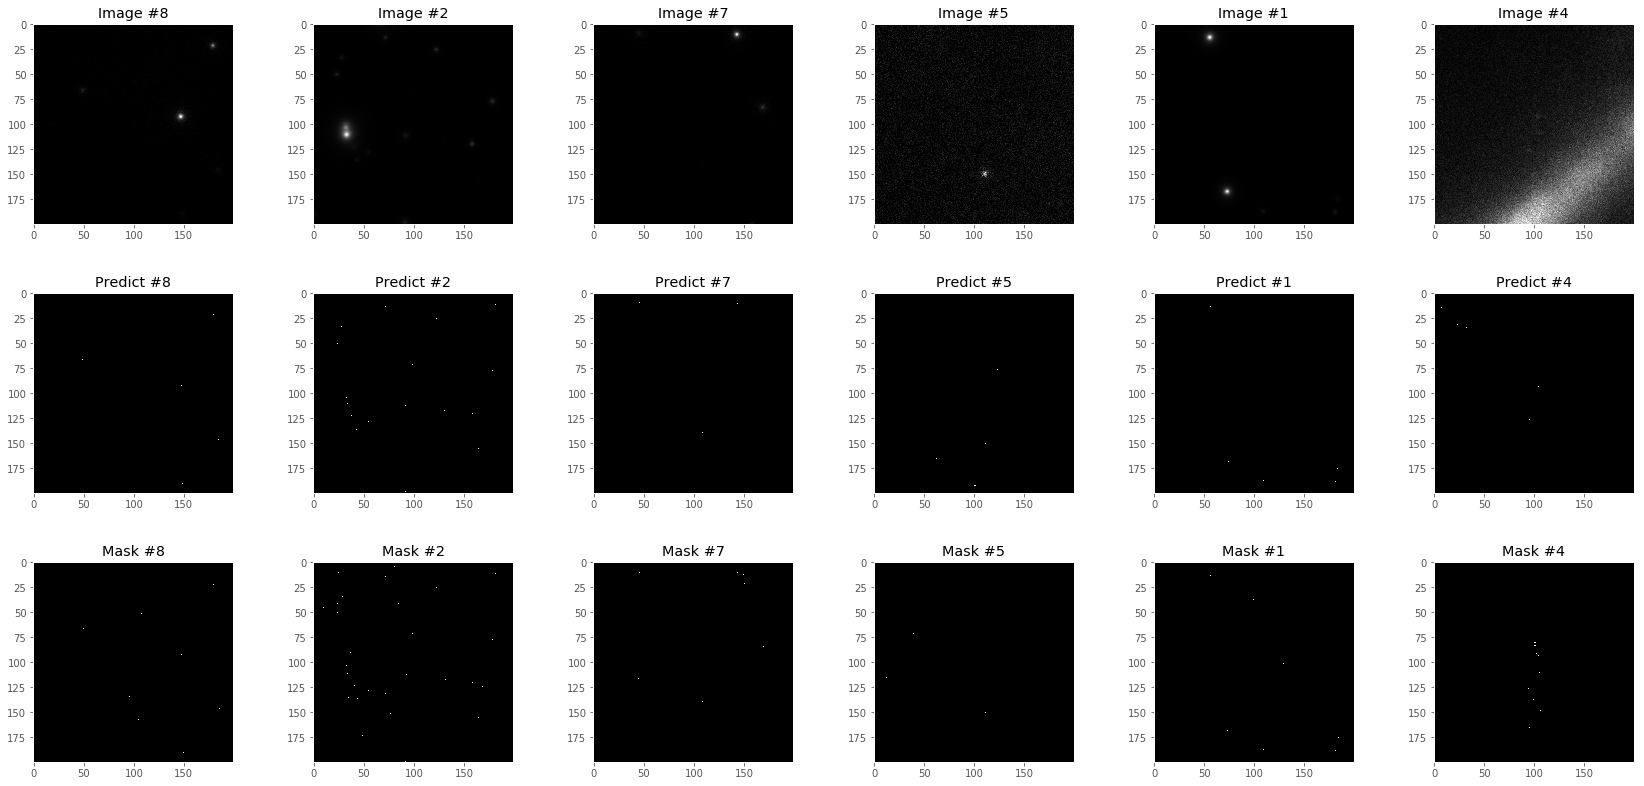

In [38]:
ix = np.random.choice(range(len(dist)), size=10)
list_img = [images[i] for i in ix]
list_pred = [preds[i] for i in ix]
list_mask = [masks[i] for i in ix]
draw_plots(6, list(zip(list_img, list_pred, list_mask)), ['Image', 'Predict', 'Mask'], hspace=-.75, figsize=(23, 23))

It is not difficult to see that the model often guesses the right answers, but still allows a lot of false negative predictions.

### Summary and further development
As a result of these studies, we can draw the following conclusions:
1. MeanShift apgorithm shows pretty good mean distance - __565__, it's better then random more then 3 times.
2. Unet architecture improve the qualiry of MeanShift more then twice and it's mean distance equal to __271__.
3. Despite the good quality, Unet model still makes a lot of false negative predictions.
4. Resulted distance hightly depends on choosing the threshold.

Further research could include the following experiments:
1. Find an optimal class weights.
2. Research better Unet parameters because this work doesn't include seach of model's parameters.
3. Optimize distance itself.
4. Try generative models.